# __Predicting Outcomes of Call Option Contracts__

# SECTION 1: Preparation

##  1.1.) Loading the python packages

In [1]:

from sklearn import datasets

# Import the modules
import numpy as np
import pandas as pd
from pathlib import Path
import random

# Load libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV
from evolutionary_search import EvolutionaryAlgorithmSearchCV

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
#from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier

#importing classification_report, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

#from sklearn.metrics import balanced_accuracy_score
#from sklearn.metrics import confusion_matrix
#from imblearn.metrics import classification_report_imbalanced

#Libraries for Saving the Model
from pickle import dump
from pickle import load

import warnings
warnings.filterwarnings('ignore')



## 1.2.) Loading the Data

In [2]:
#NOTE: This iris dataset is for debugging purposes only

#iris = datasets.load_iris()

#X = iris.data

#y = iris.target

#validation_size = 0.2

#seed = 7

In [8]:
#Import call options info

df = pd.read_csv(
    Path("../Resources/q4_21_q1_22.csv")
)


#full_df_filt.csv for 2022Q1 only
#spy_21_q4_filt.csv for 2021Q4 only

In [9]:
df.head()

,QUOTE_READTIME,CONTRACT,SPY PRICE,EXPIRE_DATE,DTE,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,C_IV,C_VOLUME,C_LAST,STRIKE,STRIKE_DISTANCE_PCT,STRIKE DISTANCE,PRICECLOSE,ROI %,y
0,2021-10-04 09:30:00,430.0 2021-10-08,432.95,2021-10-08,4.27,0.61310,0.03556,0.19356,-0.43339,0.03538,0.21263,10.0,5.93,430.0,0.007,-2.95,6.11,3.035413,2.0
1,2021-10-04 09:30:00,431.0 2021-10-08,432.95,2021-10-08,4.27,0.57914,0.03730,0.19781,-0.43196,0.03344,0.20709,1.0,5.21,431.0,0.004,-1.95,5.31,1.919386,2.0
2,2021-10-04 09:30:00,432.0 2021-10-08,432.95,2021-10-08,4.27,0.54144,0.03858,0.20139,-0.43035,0.03157,0.20271,0.0,5.61,432.0,0.002,-0.95,4.63,-17.468806,1.0
3,2021-10-04 09:30:00,433.0 2021-10-08,432.95,2021-10-08,4.27,0.50267,0.03978,0.20224,-0.42316,0.02886,0.19849,1.0,4.01,433.0,0.000,0.05,3.95,-1.496259,2.0
4,2021-10-04 09:30:00,434.0 2021-10-08,432.95,2021-10-08,4.27,0.46199,0.04063,0.20081,-0.41040,0.02677,0.19261,13.0,3.42,434.0,0.002,1.05,3.22,-5.847953,2.0


# SECTION 2: Exploratory Data Analysis

## 2.1.) Descriptive Statistics

In [10]:
df.shape

(18286, 19)

In [11]:
#Check for any null values and remove the null values
print('Null Values =', df.isnull().values.any())

#Drop NaNs
df = df.dropna()

Null Values = False


In [12]:
display(df.head())
df.tail()

,QUOTE_READTIME,CONTRACT,SPY PRICE,EXPIRE_DATE,DTE,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,C_IV,C_VOLUME,C_LAST,STRIKE,STRIKE_DISTANCE_PCT,STRIKE DISTANCE,PRICECLOSE,ROI %,y
0,2021-10-04 09:30:00,430.0 2021-10-08,432.95,2021-10-08,4.27,0.61310,0.03556,0.19356,-0.43339,0.03538,0.21263,10.0,5.93,430.0,0.007,-2.95,6.11,3.035413,2.0
1,2021-10-04 09:30:00,431.0 2021-10-08,432.95,2021-10-08,4.27,0.57914,0.03730,0.19781,-0.43196,0.03344,0.20709,1.0,5.21,431.0,0.004,-1.95,5.31,1.919386,2.0
2,2021-10-04 09:30:00,432.0 2021-10-08,432.95,2021-10-08,4.27,0.54144,0.03858,0.20139,-0.43035,0.03157,0.20271,0.0,5.61,432.0,0.002,-0.95,4.63,-17.468806,1.0
3,2021-10-04 09:30:00,433.0 2021-10-08,432.95,2021-10-08,4.27,0.50267,0.03978,0.20224,-0.42316,0.02886,0.19849,1.0,4.01,433.0,0.000,0.05,3.95,-1.496259,2.0
4,2021-10-04 09:30:00,434.0 2021-10-08,432.95,2021-10-08,4.27,0.46199,0.04063,0.20081,-0.41040,0.02677,0.19261,13.0,3.42,434.0,0.002,1.05,3.22,-5.847953,2.0


,QUOTE_READTIME,CONTRACT,SPY PRICE,EXPIRE_DATE,DTE,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,C_IV,C_VOLUME,C_LAST,STRIKE,STRIKE_DISTANCE_PCT,STRIKE DISTANCE,PRICECLOSE,ROI %,y
18281,2022-03-23 16:00:00,455.0 2022-03-25,443.84,3/25/2022,2.0,0.04696,0.01493,0.03746,-0.09216,0.00106,0.17010,12879.0,0.13,455.0,0.025,11.16,0.13,0.0,2.0
18282,2022-03-23 16:00:00,456.0 2022-03-25,443.84,3/25/2022,2.0,0.03309,0.01144,0.02826,-0.06611,0.00075,0.16963,10707.0,0.09,456.0,0.027,12.16,0.09,0.0,2.0
18283,2022-03-23 16:00:00,457.0 2022-03-25,443.84,3/25/2022,2.0,0.02264,0.00839,0.02085,-0.04539,0.00083,0.16879,4434.0,0.05,457.0,0.030,13.16,0.05,0.0,2.0
18284,2022-03-23 16:00:00,458.0 2022-03-25,443.84,3/25/2022,2.0,0.01819,0.00688,0.01736,-0.03784,0.00030,0.17380,4001.0,0.04,458.0,0.032,14.16,0.04,0.0,2.0
18285,2022-03-23 16:00:00,459.0 2022-03-25,443.84,3/25/2022,2.0,0.01514,0.00542,0.01463,-0.03065,0.00091,0.17742,2672.0,0.03,459.0,0.034,15.16,0.03,0.0,2.0


In [13]:
df.describe()

,SPY PRICE,DTE,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,C_IV,C_VOLUME,C_LAST,STRIKE,STRIKE_DISTANCE_PCT,STRIKE DISTANCE,PRICECLOSE,ROI %,y
count,18286.000000,18286.000000,18286.000000,18286.000000,18286.000000,18286.000000,18286.000000,18286.000000,18286.000000,18286.000000,18286.000000,18286.000000,18286.000000,18286.000000,18286.000000,18286.000000
mean,451.743649,3.135086,0.296418,0.031482,0.114851,-0.291012,0.012665,0.192955,5449.346331,2.356799,457.210462,0.016726,5.466812,2.715073,15.299943,2.024007
std,16.600194,0.821330,0.250829,0.020384,0.062800,0.221723,0.010645,0.084475,9287.148360,2.920379,17.087876,0.012128,7.451330,3.843939,107.873507,1.769805
min,415.920000,2.000000,0.001930,0.000860,0.002720,-1.063160,-0.000410,0.057790,0.000000,0.010000,418.000000,0.000000,-18.400000,0.010000,-97.701149,0.000000
25%,435.140000,2.210000,0.066045,0.016792,0.057870,-0.436995,0.003082,0.124293,593.250000,0.200000,443.000000,0.007000,0.290000,0.070000,-61.413869,0.000000
50%,454.760000,3.120000,0.241695,0.028100,0.126910,-0.260010,0.010540,0.174690,2222.500000,1.190000,457.000000,0.015000,5.550000,0.760000,-4.121614,2.000000
75%,466.730000,4.060000,0.479093,0.042570,0.166990,-0.095430,0.019707,0.244622,6107.750000,3.510000,472.000000,0.025000,10.807500,4.070000,48.969400,3.000000
max,479.650000,4.270000,0.957660,0.157750,0.221910,-0.003710,0.052130,0.495160,126743.000000,19.370000,491.000000,0.071000,29.620000,18.470000,912.500000,5.000000


In [14]:
df.dtypes

QUOTE_READTIME          object
CONTRACT                object
SPY PRICE              float64
EXPIRE_DATE             object
DTE                    float64
C_DELTA                float64
C_GAMMA                float64
C_VEGA                 float64
C_THETA                float64
C_RHO                  float64
C_IV                   float64
C_VOLUME               float64
C_LAST                 float64
STRIKE                 float64
STRIKE_DISTANCE_PCT    float64
STRIKE DISTANCE        float64
PRICECLOSE             float64
ROI %                  float64
y                      float64
dtype: object

## 2.2.) Feature Analysis and Exploration

### Plotting features according to contract length

In [15]:
#
#contract_outcome = df.groupby('STRIKE_DISTANCE_PCT')['y'].value_counts(normalize=True).loc[:,1]
#sns.set(rc={'figure.figsize':(12,5)})
#sns.barplot(x=contract_outcome.index, y=contract_outcome.values, color='#5975A4', saturation=1)

### Eliminate Uncorrelated Features

In [16]:
#Calculate correlation of each feature with 'y'

correlation = df.corr()
correlation_df = abs(correlation['y'])

In [17]:
correlation_df.sort_values(ascending=False)

y                      1.000000
ROI %                  0.880819
PRICECLOSE             0.471876
STRIKE                 0.204669
SPY PRICE              0.168380
C_DELTA                0.118456
C_IV                   0.116492
C_LAST                 0.116124
C_RHO                  0.110906
C_VEGA                 0.108954
STRIKE DISTANCE        0.094224
C_THETA                0.088394
C_VOLUME               0.059965
STRIKE_DISTANCE_PCT    0.053677
DTE                    0.019249
C_GAMMA                0.013348
Name: y, dtype: float64

In [18]:
#Drop variables with less than 3% correlation with contract outcome ('y')

#drop_list_corr = sorted(list(correlation_df[correlation_df < 0.015].index))
#print(drop_list_corr)

In [19]:
#Dropping because C_IV convolutes outcome for some buggish reason

df.drop(labels=["C_IV"], axis=1, inplace=True)

### Drop Columns Not Needed for Machine Learning

In [20]:
df.drop(columns=["CONTRACT"], inplace=True)

In [21]:
df.drop(columns=["ROI %"], inplace=True)

In [22]:
df.drop(columns=["PRICECLOSE"], inplace=True)

In [23]:
df.drop(columns=["EXPIRE_DATE"], inplace=True)

In [24]:
df.drop(columns=["C_VOLUME"], inplace=True)

In [25]:
df.drop(columns=["QUOTE_READTIME"], inplace=True)

# SECTION 3: Evaluate Algorithms and Models

## 3.1.) Train Test Split and Evaluation Metrics

In [26]:
#Split into training and testing groups

#Split out validation dataset for the end
y = df["y"]

X = df.drop(columns='y')


In [27]:
y.value_counts()

0.0    4738
1.0    3926
5.0    3055
2.0    3008
3.0    2442
4.0    1117
Name: y, dtype: int64

In [28]:

validation_size = 0.2

seed = 7

X_train, X_validation, y_train, y_validation = train_test_split(X, y, stratify=y, test_size=validation_size, random_state=seed)


In [29]:
X_validation

,SPY PRICE,DTE,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,C_LAST,STRIKE,STRIKE_DISTANCE_PCT,STRIKE DISTANCE
2252,450.23,3.10,0.83793,0.04573,0.11256,-0.17062,0.03893,5.72,445.0,0.012,-5.23
8845,476.65,2.23,0.04673,0.02236,0.04313,-0.05930,0.00140,0.08,484.0,0.015,7.35
9934,459.45,4.17,0.02257,0.00610,0.02959,-0.04082,0.00113,0.06,478.0,0.039,18.05
5918,463.52,4.25,0.03651,0.01076,0.04291,-0.05141,0.00244,0.11,477.0,0.029,13.48
18040,447.09,2.27,0.45884,0.04979,0.16075,-0.58115,0.01701,2.73,448.0,0.002,0.91
...,...,...,...,...,...,...,...,...,...,...,...
8188,462.16,2.10,0.07111,0.01687,0.05562,-0.15203,0.00272,0.26,473.0,0.023,10.84
10676,470.92,2.04,0.39283,0.06818,0.15759,-0.43215,0.01417,1.54,472.0,0.003,1.58
8441,475.99,4.10,0.49832,0.06275,0.21837,-0.27072,0.02995,2.50,476.0,0.000,0.01
5621,468.29,3.00,0.00791,0.00406,0.01116,-0.01085,0.00007,0.01,481.0,0.027,12.71


In [30]:
# Create the StandardScaler instance
scaler = StandardScaler()

# Fit the scaler to the features training dataset
X_scaler = scaler.fit(X_train)

# Scale both the training and testing data from the features dataset
X_train_scaled = X_scaler.transform(X_train)
X_validation_scaled = X_scaler.transform(X_validation)

## 3.2.) Quick Check of Models and Algorithms

In [31]:
#Spot check Classification algorithms

models = []

#Boosting methods

models.append(('XGB', XGBClassifier()))
models.append(('AB', AdaBoostClassifier()))
#models.append(('GBM', GradientBoostingClassifier()))

#Bagging methods

models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))

#SVC 
#models.append(('SVC', SVC()))

#K Nearest Neighbors
models.append(('KNN', KNeighborsClassifier()))


In [32]:
#Test options for classification

num_folds = 10
seed = 7

In [33]:
results = []

names = []

scoring = 'accuracy'

for name, model in models:
    kfold = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    findings_summary = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(findings_summary)

XGB: 0.880708 (0.006380)
AB: 0.467530 (0.012650)
RF: 0.866557 (0.015076)
ET: 0.864711 (0.013478)
KNN: 0.754921 (0.012586)


In [ ]:
#Compare the model outcomes

fig = pyplot.figure()
fig.suptitle('Model Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(8,4)
pyplot.show()

## 3.3.) Selecting Random Forest (or whichver tree method best), Calculating its Baseline 

In [34]:
#Estimate accuracy on training set

rf_model = RandomForestClassifier()

cv = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
scores = cross_val_score(rf_model, X_train_scaled, y_train, scoring='accuracy', cv=cv)
avg_score = np.mean(scores)
avg_score

0.8679241163473289

In [35]:
#Estimate accuracy on validation set

rf_model = RandomForestClassifier()

rf_model.fit(X_train_scaled, y_train)

predictions = rf_model.predict(X_validation_scaled)

print(accuracy_score(y_validation, predictions))

print('Weighted Precision: {:.2f}'.format(precision_score(y_validation, predictions, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_validation, predictions, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_validation, predictions, average='weighted')))

print(classification_report(y_validation, predictions, target_names=["Strong Sell", "Sell", "Pass", "Buy", "Strong Buy", "Very High Return"]))

print(confusion_matrix(y_validation, predictions))

0.8838162930563149
Weighted Precision: 0.88
Weighted Recall: 0.88
Weighted F1-score: 0.88
                  precision    recall  f1-score   support

     Strong Sell       0.93      0.94      0.93       948
            Sell       0.88      0.90      0.89       785
            Pass       0.84      0.85      0.84       602
             Buy       0.85      0.80      0.83       489
      Strong Buy       0.79      0.74      0.76       223
Very High Return       0.93      0.93      0.93       611

        accuracy                           0.88      3658
       macro avg       0.87      0.86      0.86      3658
    weighted avg       0.88      0.88      0.88      3658

[[893  38   5   3   1   8]
 [ 45 704  35   0   1   0]
 [  7  44 509  39   0   3]
 [  8  10  48 393  21   9]
 [  6   5   0  26 166  20]
 [  5   3  11   2  22 568]]


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

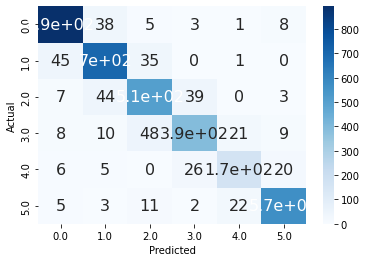

In [36]:
#Visualization of the Confusion Matrix

df_matrix = pd.DataFrame(confusion_matrix(y_validation, predictions), columns=np.unique(y_validation), index = np.unique(y_validation))
df_matrix.index.name = 'Actual'
df_matrix.columns.name = 'Predicted'
sns.heatmap(df_matrix, cmap="Blues", annot=True, annot_kws={"size": 16}) 

# SECTION 4: Model Tuning 

## 4.1.) Hyperparameter Tuning for Random Forest

### APPROACH (A) 
## __*(CAUTION TAKES A LONG TIME!)*__

In [ ]:


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {}

paramgrid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,}
              # 'min_samples_split': min_samples_split,
               #'min_samples_leaf': min_samples_leaf,
              # 'bootstrap': bootstrap}

random.seed(1)

cv = EvolutionaryAlgorithmSearchCV(estimator=RandomForestClassifier(),
                                   params=paramgrid,
                                   scoring="accuracy",
                                   cv=StratifiedKFold(n_splits=4),
                                   verbose=1,
                                   population_size=50,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=5,
                                   n_jobs=4)
cv.fit(X_train_scaled, y_train)

### APPROACH (B)
## __*(CAUTION TAKES A LONG TIME!)*__

In [ ]:
# Grid Search: (select model) Tuning

n_estimators = [20, 100, 180, 1000]
max_features = [1, 2, 3, 4]

param_grid = dict(n_estimators=n_estimators, max_features=max_features)

rf_model = RandomForestClassifier()

kfold = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)

grid = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train_scaled, y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

### PROCEEDING WITH BEST APPROACH

In [37]:
#Prepare the model with parameters decided in previous cell

rf_model = RandomForestClassifier() #(n_estimators=200, max_features="sqrt", max_depth=100, min_samples_split=5, min_samples_leaf=1, bootstrap=False)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [38]:
#Score predictions of training set

training_predictions = rf_model.predict(X_train_scaled)

print(accuracy_score(y_train, training_predictions))

print('Micro Precision: {:.2f}'.format(precision_score(y_train, training_predictions, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_train, training_predictions, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_train, training_predictions, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_train, training_predictions, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_train, training_predictions, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_train, training_predictions, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_train, training_predictions, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_train, training_predictions, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_train, training_predictions, average='weighted')))


print(classification_report(y_train, training_predictions, target_names=["Strong Sell", "Sell", "Pass", "Buy", "Strong Buy", "Very High Return"]))

1.0
Micro Precision: 1.00
Micro Recall: 1.00
Micro F1-score: 1.00

Macro Precision: 1.00
Macro Recall: 1.00
Macro F1-score: 1.00

Weighted Precision: 1.00
Weighted Recall: 1.00
Weighted F1-score: 1.00
                  precision    recall  f1-score   support

     Strong Sell       1.00      1.00      1.00      3790
            Sell       1.00      1.00      1.00      3141
            Pass       1.00      1.00      1.00      2406
             Buy       1.00      1.00      1.00      1953
      Strong Buy       1.00      1.00      1.00       894
Very High Return       1.00      1.00      1.00      2444

        accuracy                           1.00     14628
       macro avg       1.00      1.00      1.00     14628
    weighted avg       1.00      1.00      1.00     14628



In [39]:
#Score predictions of validation set

predictions = rf_model.predict(X_validation_scaled)

print(accuracy_score(y_validation, predictions))

print('Micro Precision: {:.2f}'.format(precision_score(y_validation, predictions, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_validation, predictions, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_validation, predictions, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_validation, predictions, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_validation, predictions, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_validation, predictions, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_validation, predictions, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_validation, predictions, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_validation, predictions, average='weighted')))


print(classification_report(y_validation, predictions, target_names=["Strong Sell", "Sell", "Pass", "Buy", "Strong Buy", "Very High Return"]))

print(confusion_matrix(y_validation, predictions))

0.8802624384909786
Micro Precision: 0.88
Micro Recall: 0.88
Micro F1-score: 0.88

Macro Precision: 0.86
Macro Recall: 0.86
Macro F1-score: 0.86

Weighted Precision: 0.88
Weighted Recall: 0.88
Weighted F1-score: 0.88
                  precision    recall  f1-score   support

     Strong Sell       0.92      0.94      0.93       948
            Sell       0.87      0.89      0.88       785
            Pass       0.85      0.83      0.84       602
             Buy       0.83      0.82      0.82       489
      Strong Buy       0.78      0.73      0.75       223
Very High Return       0.93      0.92      0.93       611

        accuracy                           0.88      3658
       macro avg       0.86      0.86      0.86      3658
    weighted avg       0.88      0.88      0.88      3658

[[894  37   3   4   1   9]
 [ 46 701  33   3   1   1]
 [  7  53 499  41   0   2]
 [  8   8  43 399  23   8]
 [  5   4   0  30 162  22]
 [  7   6   9   2  22 565]]


In [ ]:
#Visualization of the Confusion Matrix

df_matrix = pd.DataFrame(confusion_matrix(y_validation, predictions), columns=np.unique(y_validation), index = np.unique(y_validation))
df_matrix.index.name = 'Actual'
df_matrix.columns.name = 'Predicted'
sns.heatmap(df_matrix, cmap="Blues", annot=True, annot_kws={"size": 16}) 

## 4.2.) Determining Feature Importance

In [ ]:
#Feature importances

importances = rf_model.feature_importances_

In [ ]:
important_features = zip(X.columns, rf_model.feature_importances_)

In [ ]:
importances_df = pd.DataFrame(important_features)

In [ ]:
importances_df = importances_df.rename(columns={0: 'Feature', 1: 'Importance'})

In [ ]:
importances_df = importances_df.set_index('Feature')

In [ ]:
importances_df = importances_df.sort_values(by='Importance', ascending=False)

In [ ]:
importances_df

In [ ]:
#Plot the top 10 most important features

importances_df[0:10].plot(
    kind='barh',
    color='green',
    title='Feature Importance',
    legend=True)

## 4.2. Bayesian Optimization with HYPEROPT for XGB

## __*(CAUTION TAKES A COUPLE OF MIN!)*__

In [ ]:
#Initialize domain space for range of values 
 
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1, 9),
        'reg_alpha' : hp.quniform('reg_alpha', 40, 180, 1),
        'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }


The available hyperopt optimization algorithms are -

hp.choice(label, options) — Returns one of the options, which should be a list or tuple.

hp.randint(label, upper) — Returns a random integer between the range [0, upper).

hp.uniform(label, low, high) — Returns a value uniformly between low and high.

hp.quniform(label, low, high, q) — Returns a value round(uniform(low, high) / q) * q, i.e it rounds the decimal values and returns an integer.

hp.normal(label, mean, std) — Returns a real value that’s normally-distributed with mean and standard deviation sigma.

In [ ]:
def objective(space):
    xgb_model = xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [(X_train_scaled, y_train), (X_validation_scaled, y_validation)]
    
    xgb_model.fit(X_train_scaled, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = xgb_model.predict(X_validation_scaled)
    accuracy = accuracy_score(y_validation, pred)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

In [40]:
#Establish XGB model instance
#Fitting training dataset to model

xgb_model = xgb.XGBClassifier() #colsample_bytree=0.8056144829851541, max_depth=8, gamma=6.979438878191186, min_child_weight=10.0, reg_lambda=0.00013734197899190276, reg_alpha=0)
xgb_model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [41]:
#Predicting on training set

training_predictions = xgb_model.predict(X_train_scaled)

print(accuracy_score(y_train, training_predictions))

print('Weighted Precision: {:.2f}'.format(precision_score(y_train, training_predictions, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_train, training_predictions, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_train, training_predictions, average='weighted')))

print(classification_report(y_train, training_predictions, target_names=["Strong Sell", "Sell", "Pass", "Buy", "Strong Buy", "Very High Return"]))

0.977508887065901
Weighted Precision: 0.98
Weighted Recall: 0.98
Weighted F1-score: 0.98
                  precision    recall  f1-score   support

     Strong Sell       0.98      0.99      0.98      3790
            Sell       0.96      0.98      0.97      3141
            Pass       0.99      0.95      0.97      2406
             Buy       0.97      0.97      0.97      1953
      Strong Buy       0.98      0.97      0.98       894
Very High Return       0.99      1.00      1.00      2444

        accuracy                           0.98     14628
       macro avg       0.98      0.98      0.98     14628
    weighted avg       0.98      0.98      0.98     14628



In [42]:
#Predicting on validation set

predictions = xgb_model.predict(X_validation_scaled)

print(accuracy_score(y_validation, predictions))

print('Weighted Precision: {:.2f}'.format(precision_score(y_validation, predictions, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_validation, predictions, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_validation, predictions, average='weighted')))

print(classification_report(y_validation, predictions, target_names=["Strong Sell", "Sell", "Pass", "Buy", "Strong Buy", "Very High Return"]))

print(confusion_matrix(y_validation, predictions))

0.8892837616183707
Weighted Precision: 0.89
Weighted Recall: 0.89
Weighted F1-score: 0.89
                  precision    recall  f1-score   support

     Strong Sell       0.93      0.96      0.94       948
            Sell       0.86      0.90      0.88       785
            Pass       0.86      0.82      0.84       602
             Buy       0.85      0.80      0.82       489
      Strong Buy       0.81      0.79      0.80       223
Very High Return       0.95      0.95      0.95       611

        accuracy                           0.89      3658
       macro avg       0.88      0.87      0.87      3658
    weighted avg       0.89      0.89      0.89      3658

[[910  36   0   1   0   1]
 [ 45 705  28   6   1   0]
 [  5  63 493  39   0   2]
 [ 13  11  41 391  25   8]
 [  1   5   0  21 176  20]
 [  4   2   9   2  16 578]]


In [ ]:
#Get probabilities of predictions

pred_proba = xgb_model.predict_proba(X_validation_scaled)
pred_proba

In [ ]:
proba_df = pd.DataFrame(pred_proba.round(2))

In [ ]:
#Formatting probabilities DataFrame

proba_df["Actual"] = y_validation.reset_index(drop=True)
proba_df.columns = ["'Strong Sell' Probability", "'Sell' Probability", "'Pass' Probability", "'Buy' Probability", "'Strong Buy' Probability", "'Very High Return' Prob.", "Actual"]
proba_df

In [ ]:
#Labeling caterogires

proba_df.loc[proba_df["Actual"] == 0, "Actual"] = "Strong Sell"
proba_df.loc[proba_df["Actual"] == 1, "Actual"] = "Sell"
proba_df.loc[proba_df["Actual"] == 2, "Actual"] = "Pass"
proba_df.loc[proba_df["Actual"] == 3, "Actual"] = "Buy"
proba_df.loc[proba_df["Actual"] == 4, "Actual"] = "Strong Buy"
proba_df.loc[proba_df["Actual"] == 5, "Actual"] = "Very High Return"

proba_df.head(50)

In [ ]:
#Get ROC AUC score

roc_auc_score(y_validation, pred_proba, multi_class="ovr")

## 4.2.) Determining Feature Importance for XGBoost Model

In [ ]:
#Feature importances

importances = xgb_model.feature_importances_

In [ ]:
important_features = zip(X.columns, xgb_model.feature_importances_)

In [ ]:
importances_df = pd.DataFrame(important_features)

In [ ]:
importances_df = importances_df.rename(columns={0: 'Feature', 1: 'Importance'})

In [ ]:
importances_df = importances_df.set_index('Feature')

In [ ]:
importances_df = importances_df.sort_values(by='Importance', ascending=False)

In [ ]:
importances_df

In [ ]:
#Plot the top 10 most important features

importances_df[0:10].plot(
    kind='barh',
    color='green',
    title='Feature Importance',
    legend=True)

In [ ]:
#et_model = ExtraTreesClassifier()
#et_model.fit(X_train_scaled, y_train)

In [ ]:
#ab_model = AdaBoostClassifier()
#ab_model.fit(X_train_scaled, y_train)

In [ ]:
#gb_model = GradientBoostingClassifier()
#ab_model.fit(X_train_scaled, y_train)